Experiments with CNNs

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F

In [15]:
transform = transforms.ToTensor()

train_val_dataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)

In [16]:
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))

In [17]:
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])

In [18]:
batch_size = 32
epochs = 30
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [19]:
print("Train set contains %d images in %d batches" % (len(trainloader.dataset),len(trainloader)))
print("Validation set contains %d images in %d batches" % (len(valloader.dataset),len(valloader)))
print("Test set contains %d images in %d batches" % (len(testloader.dataset),len(testloader)))

Train set contains 48000 images in 1500 batches
Validation set contains 12000 images in 375 batches
Test set contains 10000 images in 313 batches


In [20]:
cuda = torch.cuda.is_available()
classes = ('tshirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot')

# Classifier

In [21]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=3),
            nn.Dropout2d(p=0.4),
            nn.MaxPool2d(2,2), 
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(128,84),
            nn.ReLU(),
            nn.Linear(84,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x
classifier = Classifier()
if cuda:
    classifier = classifier.cuda()
classifier

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout2d(p=0.25, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): Dropout2d(p=0.25, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): Dropout2d(p=0.4, inplace=False)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [22]:
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [23]:
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
    for images, labels in trainloader:
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        output = classifier(images)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)
  
    classifier.eval()
    total_correct = 0
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            output_acc = classifier(images)
            loss = criterion(output_acc,labels)
            current_val_loss += loss.item()*images.size(0)
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        val_loss = current_val_loss/len(valloader)
        validation_losses.append(val_loss)
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, train_loss, val_loss, accuracy))


Epoch: 1/30 	 Training Loss: 36.82363132286072, Validation loss: 20.206659477233888, Validation Accuracy: 0.7560833333333333
Epoch: 2/30 	 Training Loss: 17.400390754381817, Validation loss: 15.513746298472087, Validation Accuracy: 0.818
Epoch: 3/30 	 Training Loss: 14.218524913946787, Validation loss: 13.870310048421224, Validation Accuracy: 0.8425
Epoch: 4/30 	 Training Loss: 12.445748402277628, Validation loss: 12.170038962682089, Validation Accuracy: 0.85875
Epoch: 5/30 	 Training Loss: 11.315268074353536, Validation loss: 11.785793593088785, Validation Accuracy: 0.8628333333333333
Epoch: 6/30 	 Training Loss: 10.451327101230621, Validation loss: 10.98520199139913, Validation Accuracy: 0.8735833333333334
Epoch: 7/30 	 Training Loss: 9.805038401285808, Validation loss: 10.625880455652872, Validation Accuracy: 0.88025
Epoch: 8/30 	 Training Loss: 9.068201506137848, Validation loss: 10.499615113576253, Validation Accuracy: 0.88425
Epoch: 9/30 	 Training Loss: 8.622288004398346, Valida

Text(0, 0.5, 'Loss')

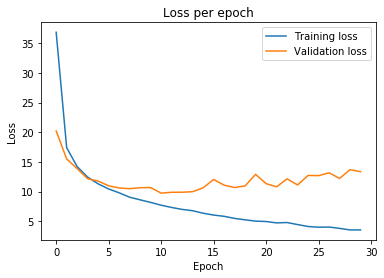

In [24]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [25]:
class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for images,labels in valloader:
    outputs = classifier(images.cuda())
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 77.581864 %
Accuracy of trouser : 97.567114 %
Accuracy of pullover : 81.459732 %
Accuracy of dress : 90.850722 %
Accuracy of  coat : 85.750210 %
Accuracy of sandal : 97.056277 %
Accuracy of shirt : 76.916868 %
Accuracy of sneaker : 95.557491 %
Accuracy of   bag : 95.727198 %
Accuracy of ankle boot : 94.865526 %


In [26]:
total_correct = 0
total_loss = 0
with torch.no_grad():
    classifier.eval()
    for images, labels in testloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images,labels = images.cuda(),labels.cuda()
        output_acc = classifier(images)
        loss = criterion(output_acc,labels)
        _, pred = torch.max(output_acc, 1)
        total_correct += torch.sum(pred==labels).item()
        total_loss += loss.item()*images.size(0)
    test_loss = total_loss/len(testloader)
    accuracy = total_correct / len(testloader.dataset)
print("Test loss: {}, accuracy: {}".format(test_loss,accuracy))

Test loss: 14.922286546268403, accuracy: 0.8831


# Autoencoder

In [27]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
auto = AutoEncoder()
if cuda:
    auto = auto.cuda()
auto

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [28]:
optimizer = optim.SGD(auto.parameters(), lr=0.5, momentum=0.9)
criterion = nn.MSELoss()

In [29]:
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
    for images, labels in trainloader:
        #images = images.view(images.size()[0], -1)
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        output = auto(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)
    
    auto.eval()
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            output = auto(images)
            loss = criterion(output,images)
            current_val_loss += loss.item()*images.size(0)
        val_loss = current_val_loss/len(valloader)
        validation_losses.append(val_loss)
    
    print('Epoch: {}/{} \t Training Loss: {} Validation Loss: {}'.format(epoch+1, epochs, train_loss,val_loss))

Epoch: 1/30 	 Training Loss: 0.36204363763332365 Validation Loss: 0.18345743370056153
Epoch: 2/30 	 Training Loss: 0.1659313854177793 Validation Loss: 0.14707123990853627
Epoch: 3/30 	 Training Loss: 0.14193857255081335 Validation Loss: 0.13518010443449022
Epoch: 4/30 	 Training Loss: 0.12898189846674601 Validation Loss: 0.12131598260005315
Epoch: 5/30 	 Training Loss: 0.12026212108631928 Validation Loss: 0.11604054588079453
Epoch: 6/30 	 Training Loss: 0.114143511886398 Validation Loss: 0.11123033018906911
Epoch: 7/30 	 Training Loss: 0.10883547260860602 Validation Loss: 0.10638538595040639
Epoch: 8/30 	 Training Loss: 0.1047237492253383 Validation Loss: 0.1008715476989746
Epoch: 9/30 	 Training Loss: 0.1012056658565998 Validation Loss: 0.0967186556259791
Epoch: 10/30 	 Training Loss: 0.0974928396269679 Validation Loss: 0.09589235101143519
Epoch: 11/30 	 Training Loss: 0.09465092704196772 Validation Loss: 0.09393466548124949
Epoch: 12/30 	 Training Loss: 0.09245034398635228 Validation

Text(0, 0.5, 'Loss')

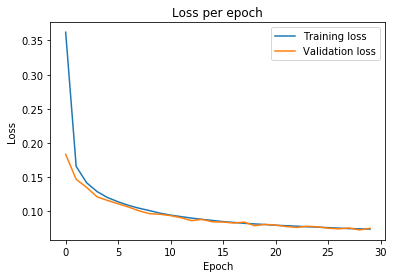

In [30]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

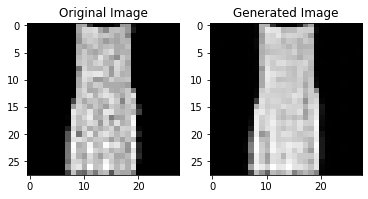

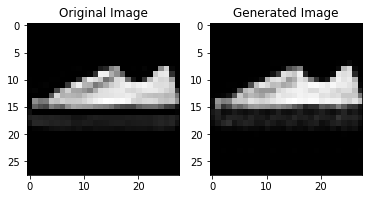

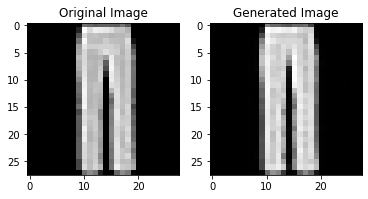

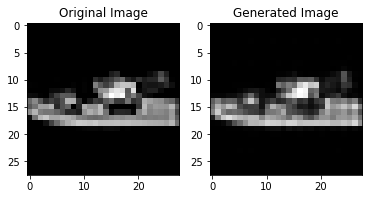

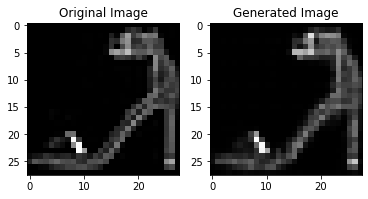

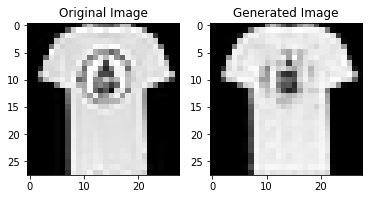

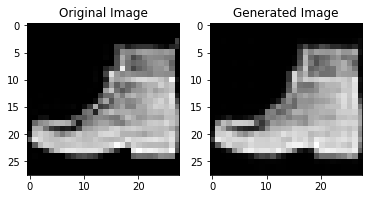

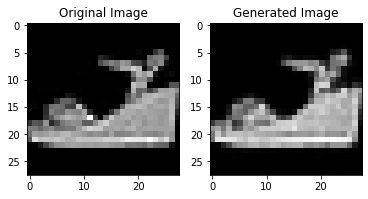

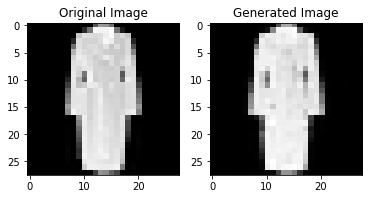

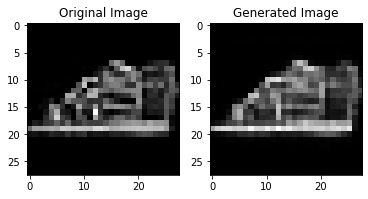

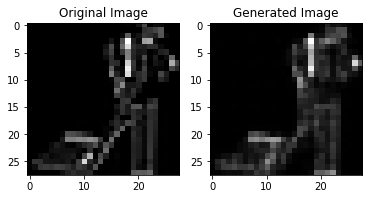

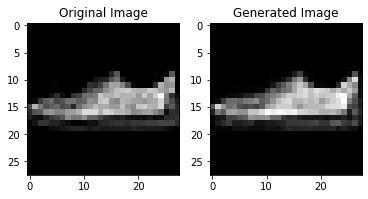

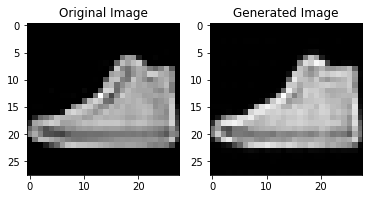

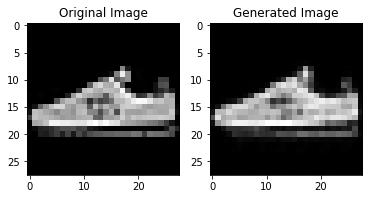

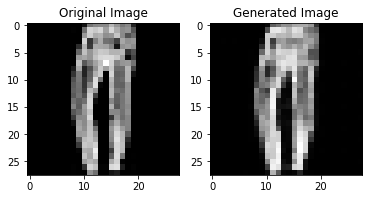

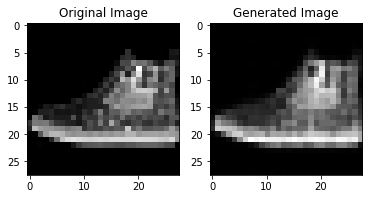

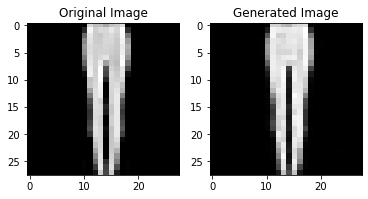

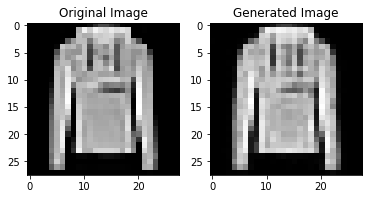

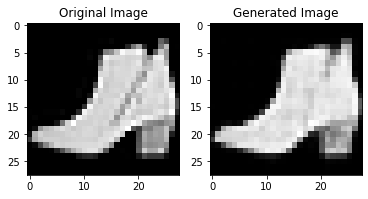

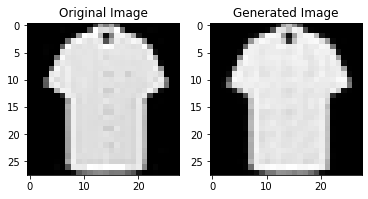

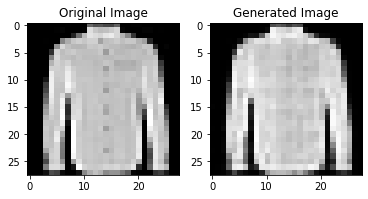

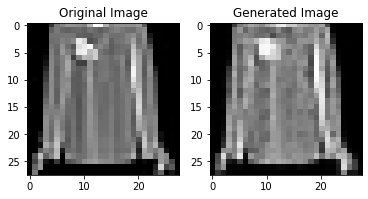

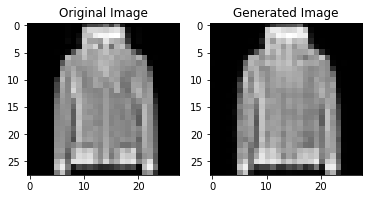

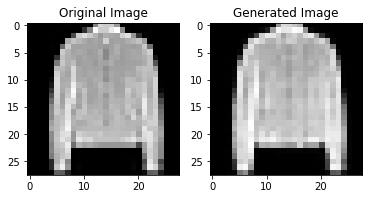

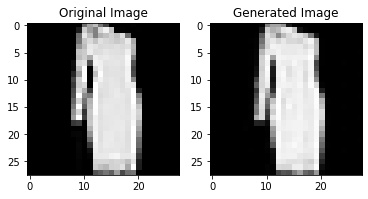

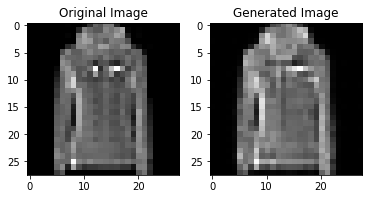

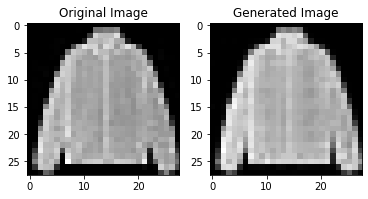

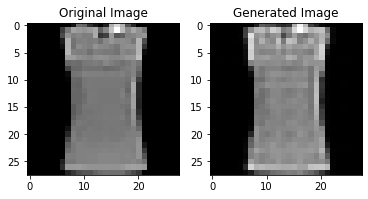

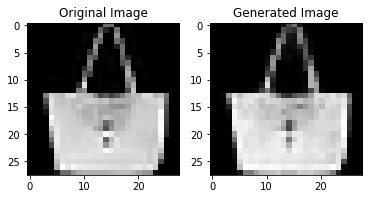

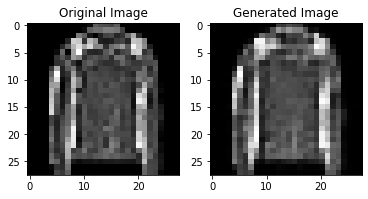

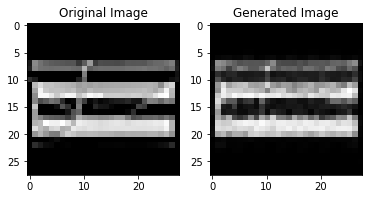

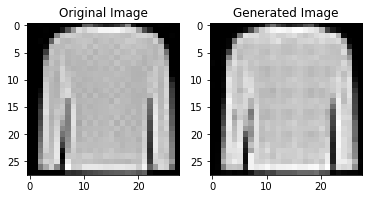

In [31]:
test_images, labels = next(iter(valloader))
#test_images = test_images.view(test_images.size()[0], -1)
if cuda:
    test_images = test_images.cuda()
test_output = auto(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

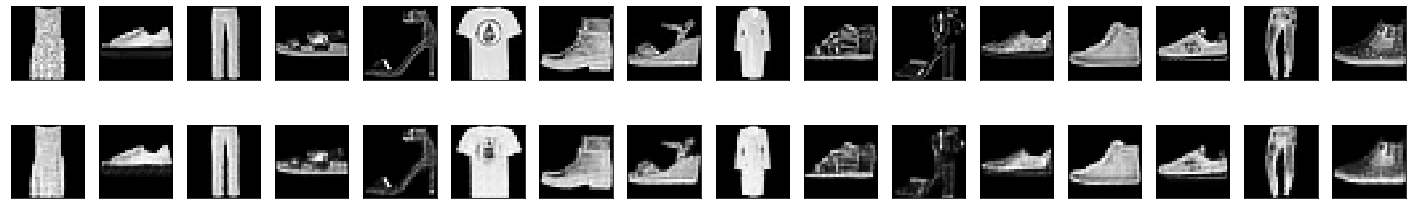

In [32]:

dataiter = iter(valloader)
images, labels = dataiter.next()
images = images.cuda()
labels = labels.cuda()

output = auto(images)                     
images = images.cpu().numpy()#
output = output.cpu()
output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()           

fig, axes = plt.subplots(nrows=2, ncols=16, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [33]:
total_loss = 0
with torch.no_grad():
    classifier.eval()
    for images, labels in testloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images,labels = images.cuda(),labels.cuda()
        output = auto(images)
        loss = criterion(output,images)
        total_loss += loss.item()*images.size(0)
    test_loss = total_loss/len(testloader)
print("Test loss: {}".format(test_loss))

Test loss: 0.0762638594633855


# Autoencoder + Classifier Combined Model (two losses)

In [34]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(3136,128),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(64,10)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(encoded.size(0),-1)
        predicted = self.classifier(encoded)
        return decoded, predicted
net3 = Mixed()
net3 = net3.cuda()
net3

Mixed(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [35]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)

In [36]:
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
  
    for images, labels in trainloader:
        
        images, labels = images.cuda(),labels.cuda()
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        decoded, predicted = net3(images)
        loss1 = criterion1(decoded,images)
        loss2 = criterion2(predicted, labels)
        loss = loss1+loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)

    net3.eval()
    total_correct = 0
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            images, labels = images.cuda(),labels.cuda()
            decoded, output_acc = net3(images)
            val_loss1 = criterion1(decoded,images)
            val_loss2 = criterion2(output_acc, labels)
            total_val_loss = val_loss1+val_loss2
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
            current_val_loss += total_val_loss.item()*images.size(0)
        val_loss = current_val_loss/len(valloader)
        validation_losses.append(val_loss)
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, train_loss, val_loss, accuracy))

Epoch: 1/30 	 Training Loss: 31.374690879185994, Validation loss: 16.994899626413982, Validation Accuracy: 0.808
Epoch: 2/30 	 Training Loss: 13.141481058597565, Validation loss: 10.855752301534016, Validation Accuracy: 0.8839166666666667
Epoch: 3/30 	 Training Loss: 10.593691843509674, Validation loss: 9.60375193977356, Validation Accuracy: 0.8964166666666666
Epoch: 4/30 	 Training Loss: 9.230624032417934, Validation loss: 9.966405719439189, Validation Accuracy: 0.8916666666666667
Epoch: 5/30 	 Training Loss: 8.396791910966238, Validation loss: 8.563343256314596, Validation Accuracy: 0.9084166666666667
Epoch: 6/30 	 Training Loss: 7.637825746933619, Validation loss: 8.588329778671264, Validation Accuracy: 0.9109166666666667
Epoch: 7/30 	 Training Loss: 7.175021513541539, Validation loss: 8.643945518493652, Validation Accuracy: 0.9073333333333333
Epoch: 8/30 	 Training Loss: 6.629679760575295, Validation loss: 7.780614501635234, Validation Accuracy: 0.9180833333333334
Epoch: 9/30 	 Tra

Text(0, 0.5, 'Loss')

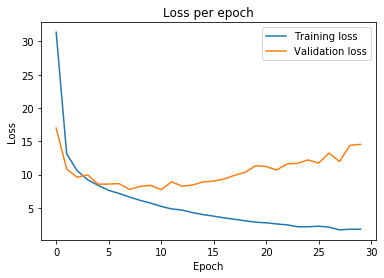

In [37]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

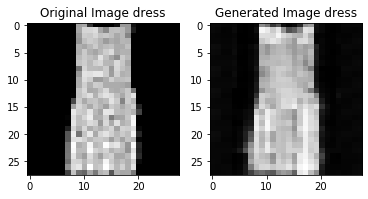

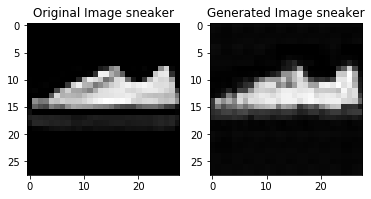

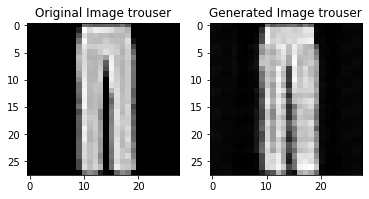

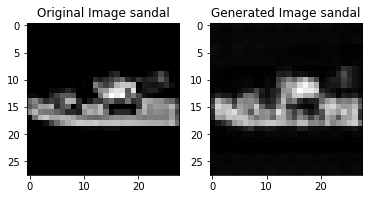

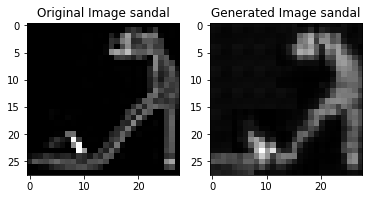

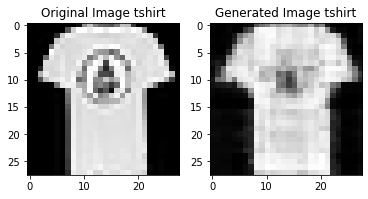

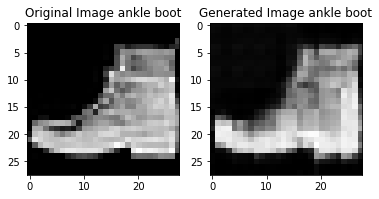

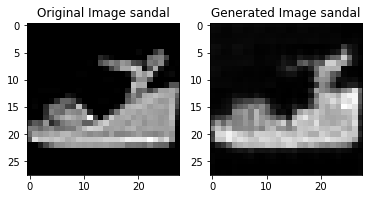

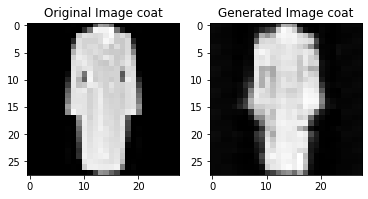

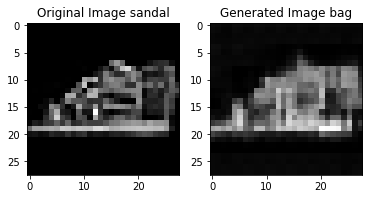

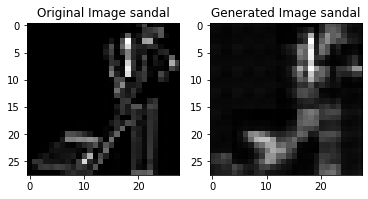

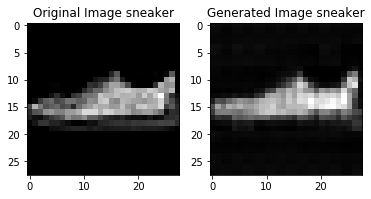

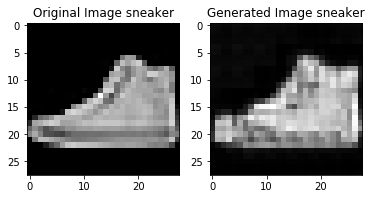

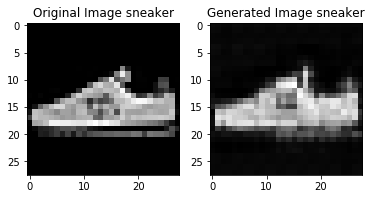

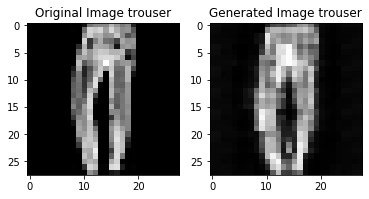

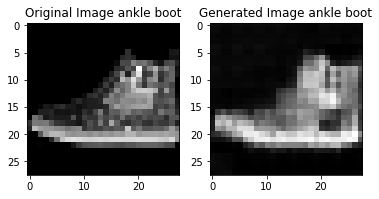

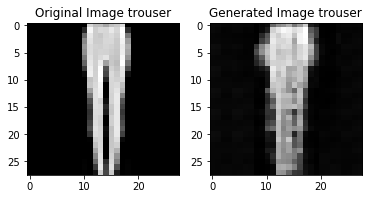

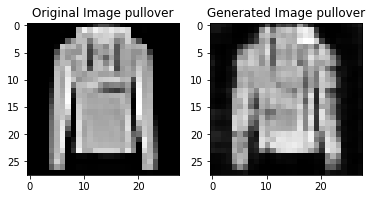

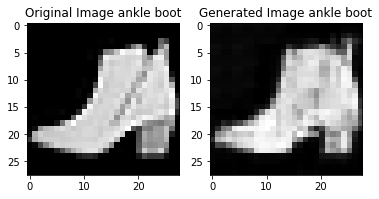

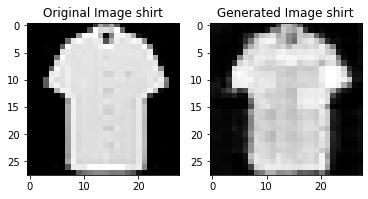

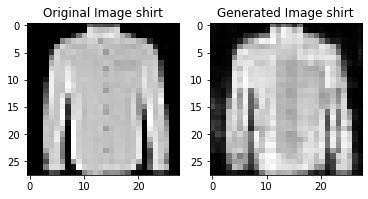

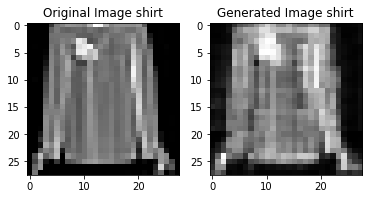

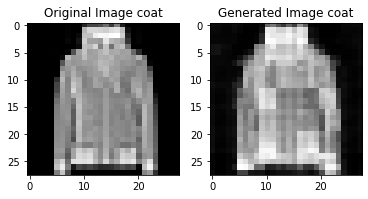

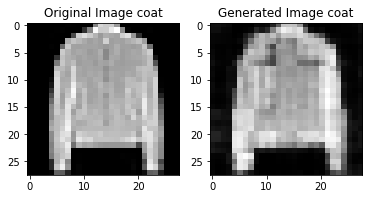

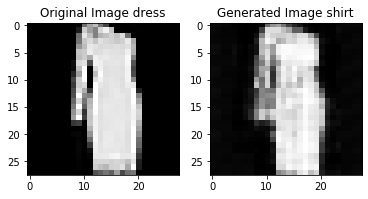

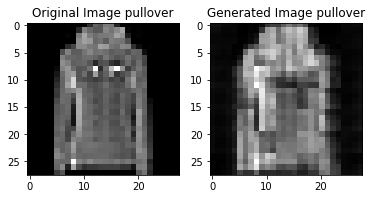

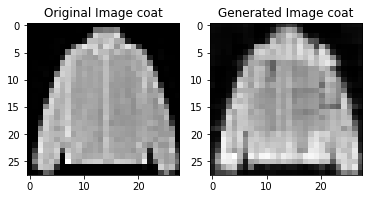

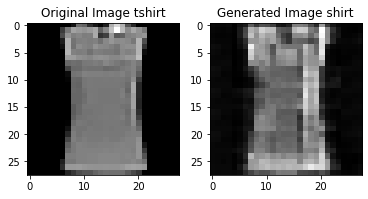

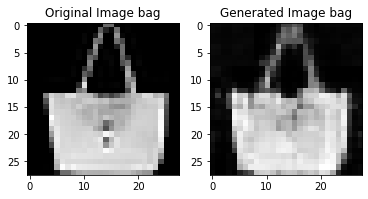

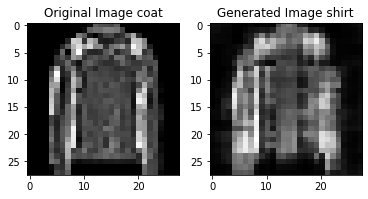

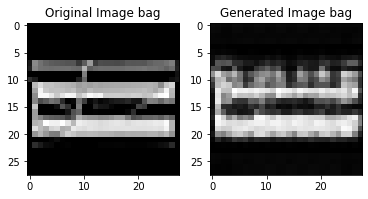

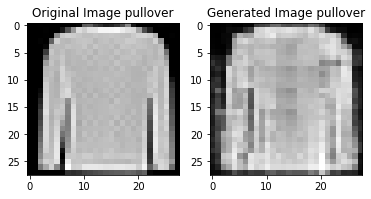

In [38]:
test_images, labels = next(iter(valloader))

#test_images = test_images.view(test_images.size()[0], -1).cuda()
test_images, labels = test_images.cuda(),labels.cuda()
test_output, predicted = net3(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    #print("Ground truth", classes[labels[i]])
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    #print("Predicted", classes[predicted_label[i]])
    plt.show()

In [39]:
class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for images,labels in valloader:
    #decoded, outputs = net3(Variable(images.view(-1, 28*28).cuda()))
    decoded, outputs = net3(images.cuda())
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 88.581024 %
Accuracy of trouser : 97.902685 %
Accuracy of pullover : 84.983221 %
Accuracy of dress : 91.412520 %
Accuracy of  coat : 84.492875 %
Accuracy of sandal : 97.056277 %
Accuracy of shirt : 81.033091 %
Accuracy of sneaker : 97.648084 %
Accuracy of   bag : 97.781430 %
Accuracy of ankle boot : 96.903015 %


In [40]:
total_correct = 0
total_loss = 0
with torch.no_grad():
    net3.eval()
    for images, labels in testloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images,labels = images.cuda(),labels.cuda()
        decoded, output_acc = net3(images)
        test_loss1 = criterion1(decoded,images)
        test_loss2 = criterion2(output_acc, labels)
        test_loss = test_loss1+test_loss2
        _, pred = torch.max(output_acc, 1)
        total_correct += torch.sum(pred==labels).item()
        total_loss += test_loss.item()*images.size(0)
    final_loss = total_loss/len(testloader)
    accuracy = total_correct / len(testloader.dataset)
print("Test loss: {}, accuracy: {}".format(final_loss,accuracy))

Test loss: 15.79760099161928, accuracy: 0.9113


# Cells currently not in use

In [9]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x
auto = Autoencoder()
if cuda:
    auto = auto.cuda()
auto

Autoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [ ]:
#NOT IN USE
correct = 0
total = 0
with torch.no_grad():
    for images,labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        decoded, output_acc = net(images)
        _, predicted = torch.max(output_acc, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network: %.3f %%' % (
    100 * correct / total))

In [ ]:
#NOT CURRENTLY IN USE - TRAINING THE AUTOENCODER BY ITSELF
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, images.view(images.size()[0], -1))
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
    print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss))

In [8]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x
auto = Autoencoder()
if cuda:
    auto = auto.cuda()
auto

Autoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
classifier = Classifier()
if cuda:
    classifier = classifier.cuda()
classifier


In [ ]:
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        output = net(images)
        #print(images.shape) #16x784
        #print(labels.shape) #16
        #print(output.shape) #16x10
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
  

    net.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            output_acc = net(images)
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        accuracy = total_correct / len(testloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Test Accuracy: {}'.format(epoch, epochs, runningloss, accuracy))

